In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular expressions
import scipy.stats
import datetime as dt
%matplotlib inline
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn  import preprocessing
from sklearn.decomposition import PCA 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, GridSearchCV

#specifically nlp stuff

import re
from nltk.corpus import  stopwords
from collections import Counter
import nltk
from sklearn.model_selection import train_test_split

#needed to generate data for doc2vec
import csv
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import TaggedDocument
import spacy
import en_core_web_sm  # or any other model you downloaded via spacy download or pip
import gensim
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
nlp = en_core_web_sm.load()

D:\Anaconda\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
D:\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#import cleaned database
music = pd.read_csv(r'C:\Users\Sean\Documents\Thinkful\RAP NLP\CSV\music_second_clean.csv')

# Parse Lyrics

In [4]:
#convert to string - this takes a while
music.lyrics = music.lyrics.astype(str)
#parse data
lyrics = music.lyrics.apply(lambda x: nlp(x))

In [5]:
#add parsed lyric data to music dataframe
music['parsed_lyrics'] = lyrics
music['parsed_lyrics'].astype(str)

0       party people in the place. embrace the bass as...
1       here i am raw. terrorist here to bring trouble...
2       let it roll get bold i just cant hold. back or...
3       talk about ever meeting ms right. but one thin...
4       yo on the mic right about now i go by the name...
5       mmm mmm mmm. aw yea im with this. im just gonn...
6       hear ye hear ye from far and near. the one the...
7       funky. ready. funky funky ahhh. one two one tw...
8       who is the man with the master plan. dj mister...
9       grab a hold of yourself open your eyes. get wi...
10      dr harrah is mr kane loose in this hospital. i...
11      here comes the conquering brother that fathoms...
12      the kiss of death on a rap pick. then you get ...
13      on and on and on and on. me say the beat dont ...
14      so out of the mercy of allah. and the law writ...
15      well excuse me take a few minutes to mellow ou...
16      yo whassup big daddy. aiyyo whassup red alert ...
17      he has

# doc2vec

In [6]:
# lyrics need to be tokenized for doc2vec
import nltk
music['tokenized_lyrics'] = music.apply(lambda row: nltk.word_tokenize(row['lyrics']), axis=1)

In [7]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re

lmtzr = WordNetLemmatizer()
w = re.compile("\w+",re.I)

In [10]:
def label_sentences(df):
    labeled_sentences = []
    for index, datapoint in df.iterrows():
        tokenized_words = re.findall(w,datapoint["lyrics"].lower())
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))
    return labeled_sentences

In [8]:
def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(alpha=0.025, min_alpha=0.025, )
    model.build_vocab(labeled_sentences)
    for epoch in range(10):
        model.train(labeled_sentences, total_examples=1030, epochs=5)
        model.alpha -= 0.002 
        model.min_alpha = model.alpha
    
    return model

In [11]:
#use taggeddocument instead of labeled sentences in the function above to avoid deprecation warning
labelledlyrics = label_sentences(music)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [12]:
model = train_doc2vec_model(labelledlyrics)

In [16]:
def vectorize_comments(df,d2v_model):
    y = []
    comments = []
    for i in range(0,df.shape[0]):
        label = 'SENT_%s' %i
        comments.append(d2v_model.docvecs[label])
    df['vectorized_lyrics'] = comments
    
    return df

In [161]:
model.save('labelledlyrics.doc2vec')

In [15]:
model.wv.most_similar('house')

[('crib', 0.44318342208862305),
 ('tunnel', 0.389350950717926),
 ('nightlife', 0.3737543821334839),
 ('nasty', 0.3666301369667053),
 ('range', 0.366048127412796),
 ('dawgs', 0.3647158741950989),
 ('spouse', 0.3587651550769806),
 ('natives', 0.35479438304901123),
 ('stanking', 0.35309159755706787),
 ('car', 0.34949934482574463)]

In [18]:
#use the function defined above to get the vectors into the dataframe
doc2vecdf = vectorize_comments(music,model)
doc2vecdf = doc2vecdf.drop('parsed_lyrics', 1)
print (doc2vecdf.head(2))

   acousticness               album          artist  danceability  \
0        0.0556  Long Live The Kane  Big Daddy Kane         0.857   
1        0.0186  Long Live The Kane  Big Daddy Kane         0.909   

   disc_number  duration_ms  energy  instrumentalness  is_explicit  key  ...  \
0            1       295333   0.797          0.000016        False   11  ...   
1            1       344960   0.666          0.000003        False    4  ...   

   popularity     region release_date  speechiness    tempo  time_signature  \
0        26.0  eastcoast         1988        0.328   99.327             4.0   
1        33.0  eastcoast         1988        0.334  110.681             4.0   

   track_number valence                                   tokenized_lyrics  \
0           1.0   0.612  [party, people, in, the, place, ., embrace, th...   
1           2.0   0.705  [here, i, am, raw, ., terrorist, here, to, bri...   

                                   vectorized_lyrics  
0  [-1.627996, 0.203352

In [19]:
#get vector array into dataframe
vectorlist = doc2vecdf["vectorized_lyrics"].T.tolist()

In [20]:
vector_df = pd.DataFrame(vectorlist)   

In [21]:
print(music)

      acousticness                   album           artist  danceability  \
0         0.055600      Long Live The Kane   Big Daddy Kane         0.857   
1         0.018600      Long Live The Kane   Big Daddy Kane         0.909   
2         0.000359      Long Live The Kane   Big Daddy Kane         0.800   
3         0.020600      Long Live The Kane   Big Daddy Kane         0.757   
4         0.071000      Long Live The Kane   Big Daddy Kane         0.726   
5         0.005690      Long Live The Kane   Big Daddy Kane         0.836   
6         0.027500      Long Live The Kane   Big Daddy Kane         0.939   
7         0.115000      Long Live The Kane   Big Daddy Kane         0.876   
8         0.014500      Long Live The Kane   Big Daddy Kane         0.843   
9         0.000204      Long Live The Kane   Big Daddy Kane         0.906   
10        0.020200  It's A Big Daddy Thing   Big Daddy Kane         0.867   
11        0.087400  It's A Big Daddy Thing   Big Daddy Kane         0.873   

[1255 rows x 27 columns]


# T-SNE Clustering

In [22]:
import numpy as np
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, method='exact', perplexity=10, n_iter=800)
vectordf_embedded = tsne.fit_transform(vector_df)

In [23]:
music['song_vector_tsne_1'] = vectordf_embedded[:,0]
music['song_vector_tsne_2'] = vectordf_embedded[:,1]

In [24]:
#need to subselect from main dataframe in order to be able to plot
kendrick = music[music['artist'].isin(['Kendrick Lamar', 'Eminem'])]

Text(38.66824652874229, 0.5, 'Song vector Dimension 2')

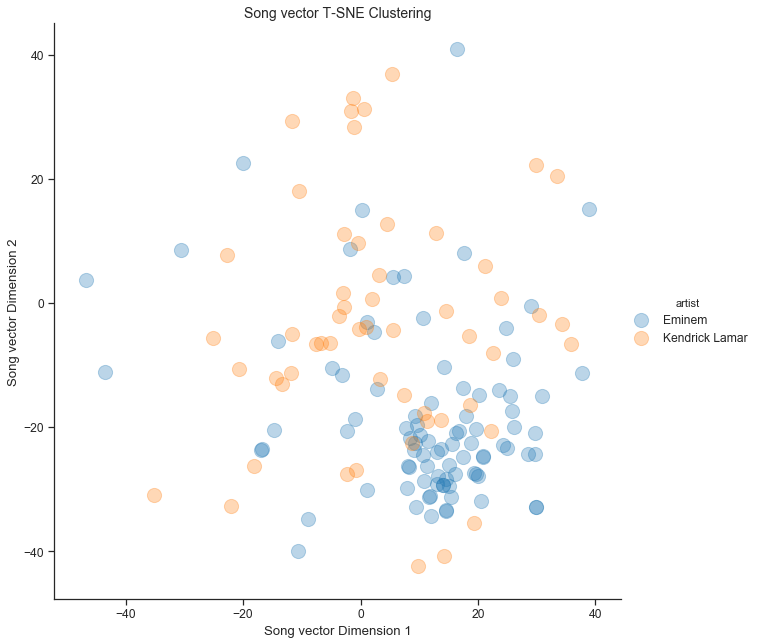

In [25]:
sns.set_context('notebook', font_scale=1.1)
sns.set_style('ticks')

sns.lmplot(x = 'song_vector_tsne_1',
          y = 'song_vector_tsne_2',
          data=kendrick,
          fit_reg=False,
          legend=True,
          height=9,
          hue='artist',
          scatter_kws={'s' : 200, 'alpha' :0.3}
)
plt.title('Song vector T-SNE Clustering').set_fontsize('14')
plt.xlabel('Song vector Dimension 1')
plt.ylabel('Song vector Dimension 2')

In [26]:
#need to subselect from main dataframe in order to be able to plot
kendrick = music[music['artist'].isin(['Kendrick Lamar', '2Pac'])]

Text(38.66824652874229, 0.5, 'Song vector Dimension 2')

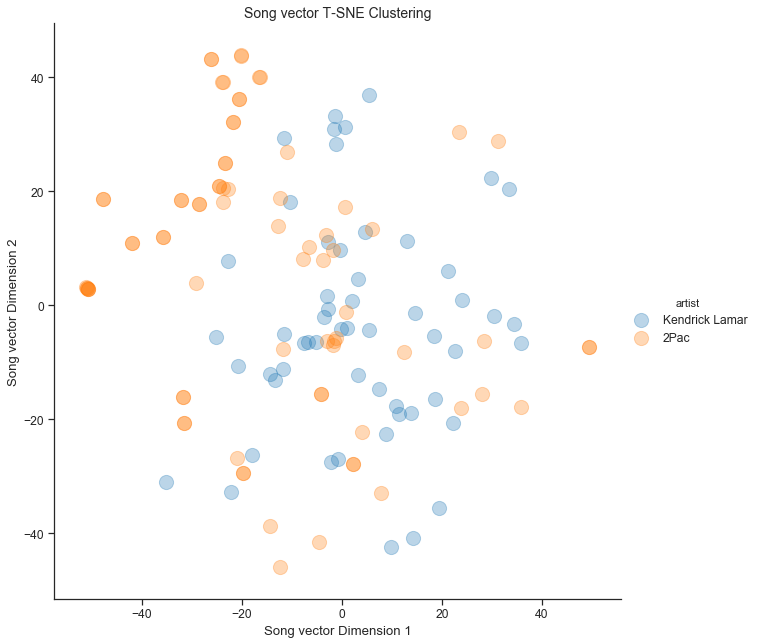

In [27]:
sns.set_context('notebook', font_scale=1.1)
sns.set_style('ticks')

sns.lmplot(x = 'song_vector_tsne_1',
          y = 'song_vector_tsne_2',
          data=kendrick,
          fit_reg=False,
          legend=True,
          height=9,
          hue='artist',
          scatter_kws={'s' : 200, 'alpha' :0.3}
)
plt.title('Song vector T-SNE Clustering').set_fontsize('14')
plt.xlabel('Song vector Dimension 1')
plt.ylabel('Song vector Dimension 2')

In [28]:
#some of these artists overlap...instead let's plot the means
tsne_meansandsd_by_artist = music.groupby(['artist'])['song_vector_tsne_1', 'song_vector_tsne_2'].mean()
tsne_meansandsd_by_artist['sd1'] = music.groupby(['artist'])['song_vector_tsne_1'].std()
tsne_meansandsd_by_artist['sd2'] = music.groupby(['artist'])['song_vector_tsne_2'].std()
tsne_meansandsd_by_artist['artist'] = tsne_meansandsd_by_artist.index
#remove artists with smaller sample sizes
tsne_meansandsd_by_artist = tsne_meansandsd_by_artist.drop(index = 'Dolemite')
tsne_meansandsd_by_artist = tsne_meansandsd_by_artist.drop(index = 'Mobb Deep')
tsne_meansandsd_by_artist = tsne_meansandsd_by_artist.drop(index = 'Rakaa (Iriscience)')
tsne_meansandsd_by_artist = tsne_meansandsd_by_artist.drop(index = 'Southside')
tsne_meansandsd_by_artist = tsne_meansandsd_by_artist.drop(index = 'Twista')
tsne_meansandsd_by_artist = tsne_meansandsd_by_artist.drop(index = 'Busta Rhymes/Jamal')
print(tsne_meansandsd_by_artist['sd1'])

artist
2Pac                    23.016527
Big Daddy Kane          11.245454
Busta Rhymes            16.125978
Common                  22.987553
Dilated Peoples         11.907372
Dr. Dre                 16.669350
E-40                    11.490680
Eazy-E                   9.408947
Eminem                  15.325020
J. Cole                 16.515459
Jeezy                   12.075545
KIDS SEE GHOSTS         14.423836
Kanye West              15.868087
Kendrick Lamar          16.072424
Killer Mike             14.309436
Mac Miller              17.411903
Nas                     18.833559
OutKast                 15.848756
Snoop Dogg              12.683996
T.I.                    10.692038
The Notorious B.I.G.    15.648825
Name: sd1, dtype: float32


In [29]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Scatter(
    x=tsne_meansandsd_by_artist["song_vector_tsne_1"],
    y=tsne_meansandsd_by_artist["song_vector_tsne_2"],
    mode='markers',
    text=tsne_meansandsd_by_artist["artist"],
    marker=dict(
        color=np.random.randn(500),
        size=tsne_meansandsd_by_artist['sd1'],
    )
)

data = [trace0]
layout = go.Layout(
    title=go.layout.Title(
        text='Doc2Vec TSNE centroids plotted by artist (size corresponds to standard deviation along x-axis)',
        xref='paper',
        x=0)
    )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bubblechart-color')

D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [30]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Scatter(
    x=music["song_vector_tsne_1"],
    y=music["song_vector_tsne_2"],
    mode='markers',
    text=music["artist"]
)

data = [trace0]
layout = go.Layout(
    title=go.layout.Title(
        text='Doc2Vec TSNE centroids plotted by artist (size corresponds to standard deviation along x-axis)',
        xref='paper',
        x=0)
    )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='tsneplots')

D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [31]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Scatter(
    x=music["song_vector_tsne_1"],
    y=music["song_vector_tsne_2"],
    mode='markers',
    text=music["name"],
    marker=dict(
        color='rgba(17, 157, 255, 0.4)',
    )
)

data = [trace0]
layout = go.Layout(
    title=go.layout.Title(
        text='Individual Doc2Vec TSNE results with song title annotated',
        xref='paper',
        x=0),
    yaxis=dict(
        range=[-60, 60])
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='tsnebysong')

D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



There is no clear pattern regarding song theme and resolution in this 2 dimensional space. Let's try to plot the results by song sentiment.

In [32]:
#import vader and write a function that will generate a sentiment score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [33]:
music['sentiment'] = music.lyrics.apply(sentiment_analyzer_scores)

In [34]:
#strip sentiment data out of dictionary and into seperate columns
sentiment=music['sentiment'].apply(pd.Series)
print(music)
music['compound'] = sentiment['compound']

      acousticness                   album           artist  danceability  \
0         0.055600      Long Live The Kane   Big Daddy Kane         0.857   
1         0.018600      Long Live The Kane   Big Daddy Kane         0.909   
2         0.000359      Long Live The Kane   Big Daddy Kane         0.800   
3         0.020600      Long Live The Kane   Big Daddy Kane         0.757   
4         0.071000      Long Live The Kane   Big Daddy Kane         0.726   
5         0.005690      Long Live The Kane   Big Daddy Kane         0.836   
6         0.027500      Long Live The Kane   Big Daddy Kane         0.939   
7         0.115000      Long Live The Kane   Big Daddy Kane         0.876   
8         0.014500      Long Live The Kane   Big Daddy Kane         0.843   
9         0.000204      Long Live The Kane   Big Daddy Kane         0.906   
10        0.020200  It's A Big Daddy Thing   Big Daddy Kane         0.867   
11        0.087400  It's A Big Daddy Thing   Big Daddy Kane         0.873   

[1255 rows x 30 columns]


In [35]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Scatter(
    x=sentiment["compound"],
    y=music["song_vector_tsne_1"],
    mode='markers',
    text=music["name"],
    marker=dict(
        color='rgba(16, 50, 255, 0.4)',
    )
)

data = [trace0]
layout = go.Layout(
    title=go.layout.Title(
        text='Doc2Vec TSNE1 plotted against Vader compound sentiment',
        xref='paper',
        x=0)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='compoundtsne1')

D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [36]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Scatter(
    x=sentiment["compound"],
    y=music["song_vector_tsne_2"],
    mode='markers',
    text=music["name"],
    marker=dict(
        color='rgba(16, 50, 255, 0.4)',
    )
)

data = [trace0]
layout = go.Layout(
    title=go.layout.Title(
        text='Doc2Vec TSNE1 plotted against Vader compound sentiment',
        xref='paper',
        x=0)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='compoundtsne2')

D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Once, again - there's no clear relationship here. There does seem to be some correlation between compound score and and TSNE1 and 2. TSNE1 seems positively correlated and TSNE2 seems negatively correlated, but it's not strong effect.

# Bag of Words

In [39]:
#create seperate df for BOW
bow_df = pd.DataFrame()
bow_df['lyrics']=music['lyrics']

In [40]:
#use sklearn countvectorizer to generate bow features, feed it the cleaned master list above so we get those counts and those counts only..
from sklearn.feature_extraction.text import CountVectorizer
bowcv = CountVectorizer(strip_accents= 'ascii', stop_words= 'english', max_features= 300, min_df= 0.15)
sklearnbow = bowcv.fit_transform(bow_df['lyrics'])

In [41]:
newarray = sklearnbow.toarray()

newarray.shape

print(bowcv.get_feature_names())

['aint', 'ask', 'ass', 'away', 'baby', 'bad', 'beat', 'best', 'better', 'big', 'bitch', 'bitches', 'black', 'blow', 'bout', 'boy', 'break', 'bring', 'bust', 'came', 'cause', 'check', 'come', 'coming', 'crazy', 'damn', 'day', 'dead', 'dick', 'did', 'didnt', 'die', 'doing', 'dont', 'drop', 'em', 'end', 'everybody', 'eyes', 'face', 'feel', 'fuck', 'fucking', 'game', 'getting', 'girl', 'god', 'going', 'gone', 'gong', 'gonna', 'good', 'got', 'gotta', 'guess', 'hard', 'hate', 'head', 'hear', 'heard', 'heart', 'hell', 'hey', 'high', 'hit', 'hoes', 'hold', 'home', 'hood', 'hope', 'hot', 'house', 'id', 'ill', 'im', 'ima', 'ive', 'just', 'kill', 'know', 'leave', 'left', 'let', 'lets', 'life', 'like', 'listen', 'little', 'live', 'living', 'long', 'look', 'looking', 'lot', 'love', 'make', 'making', 'man', 'mean', 'mind', 'money', 'motherfucker', 'need', 'new', 'nigga', 'niggas', 'night', 'oh', 'old', 'people', 'place', 'play', 'pull', 'rap', 'ready', 'real', 'really', 'ride', 'right', 'rock', 'rol

In [42]:
#need to put newarray into the BOW df with the column names....
bow_df = pd.DataFrame(newarray, columns = bowcv.get_feature_names())

In [43]:
print(bow_df)

      aint  ask  ass  away  baby  bad  beat  best  better  big  ...  word  \
0        2    0    0     0     0    0     0     0       1    3  ...     0   
1        1    0    0     0     0    0     0     0       1    0  ...     0   
2        1    1    0     0     0    0     0     1       1    2  ...     0   
3        0    0    0     3     1    0     0     0       0    0  ...     0   
4        0    0    0     0     0    0     0     0       0    4  ...     0   
5       11    0    0     0     0    0     2     2       1   13  ...     2   
6        2    1    0     0     0    0     0     0       0    1  ...     0   
7        0    0    0     0     0    0     1     1       0    2  ...     0   
8        0    0    0     0     0    0     0     0       0    4  ...     0   
9        0    0    0     1     0    0     1     0       0    2  ...     1   
10       5    0    0     0     0    0     0     0       0   11  ...     0   
11       1    0    0     1     0    0     0     0       1    2  ...     0   

[1255 rows x 170 columns]


In [44]:
#export alldata with features generated

bow_df.to_csv (r'C:\Users\Sean\Documents\Thinkful\RAP NLP\CSV\bowdf.csv', index = None, header=True)

music.to_csv (r'C:\Users\Sean\Documents\Thinkful\RAP NLP\CSV\originaldataframewithdoc2vecandtsne.csv', index = None, header=True)

# PCA on BOW
PCA has previously been shown to be an optimal approach towards dimension reduction with BOW [1]. Accordingly we will employ PCA to reduce the dimensionality of the BOW data.

1. http://cs229.stanford.edu/proj2017/final-reports/5163902.pdf

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [46]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(bow_df)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by StandardScaler.

D:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by StandardScaler.



In [49]:
sklearn_pca = PCA()
Y= sklearn_pca.fit_transform(X)

Explained variance of first 4 values is:
0.12432103718145059


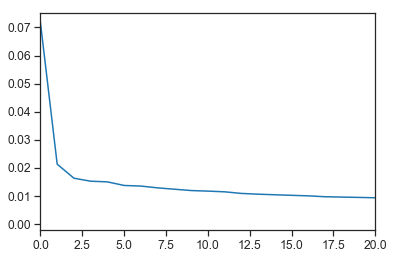

In [50]:
evr = sklearn_pca.explained_variance_ratio_
plt.plot(evr)
plt.xlim([0,20])


print('Explained variance of first 4 values is:')
print(np.sum(evr[:4]))

This PCA didn't turn do a great job of condensing the variance. Due to dimensionality concerns and 
the strong possibility of overfitting to the BOW results, let's try out the first 4 PCA components in our models/clusters.
First let's export the results:

In [51]:
PCAresults_df = pd.DataFrame(Y)
print(PCAresults_df)

           0         1         2         3         4         5         6    \
0    -0.021920  1.885310  0.141977 -0.024453 -0.266983 -0.094080  0.558797   
1    -1.402926 -0.270258 -0.033821 -1.159841 -0.273729 -0.556474 -0.329806   
2    -2.205547  0.337053  0.043309 -0.835345 -0.163963 -0.417685  0.561342   
3    -0.248872  2.463201 -0.940857  0.819983  1.356771 -0.750977 -0.693077   
4     0.002168  1.004039  0.870709 -1.044465 -0.497651 -0.090579  0.544973   
5     2.158641  1.527804 -0.073875 -1.311818 -1.004896 -0.821780  0.520043   
6    -2.383554  1.499548  0.531790 -0.404505  0.114178 -0.649319 -0.659191   
7    -0.245374  1.427817  1.207267 -0.317645 -0.728603 -0.338136  0.707629   
8    -1.098811  0.279370  0.371436 -2.079350  0.400879 -0.089619  0.049922   
9    -2.944924  0.375822  0.632623  0.315275 -0.398929 -0.847662 -0.098024   
10   -0.622970  1.396887 -0.136619  0.057862 -0.024442 -0.438815  0.511339   
11   -0.829462  0.637523 -0.379705  0.080888  0.616235 -0.451024

[1255 rows x 170 columns]


In [52]:
PCAresults_df.to_csv (r'C:\Users\Sean\Documents\Thinkful\RAP NLP\CSV\pcaresults.csv', index = None, header=True)

# Data Exploration

Before we delve into data exploration it should be noted that our features are contained within seperate dataframes.
The PCAresults_df dataframe contains all of the PCA results for the BOW data.
The bow_df dataframe containts the BOW data.
The music dataframe cotnains all other data including tokenized lyrics, parsed lyrics, doc2vec vectors and the TSNE results.


In [53]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np


data = [go.Histogram(x=music['artist'])]

nbinsx=12

layout = go.Layout(
    title='Distribution of songs by artist',
    xaxis=dict(
        title='artist'
    ),
    yaxis=dict(
        title='# of songs'
    ),
    bargap=0.1,
    bargroupgap=0.1
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styled histogram')

D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



There's some class imbalance. That we will need to fix here. Lets' drop the following:
Dolemite, Twista, Mobb Deep, Southside, Rakka (Iriscience), Kids See Ghosts.
Also let's add the Busta Rhymes/Jamal entries to Busta Rhymes.

# Creating holdouts

In [54]:
modellingfeatures = pd.DataFrame()
modellingfeatures = PCAresults_df.iloc[:,:4]
modellingfeatures['d2v_tsne_1'] = music['song_vector_tsne_1']
modellingfeatures['d2v_tsne_2'] = music['song_vector_tsne_2']
modellingfeatures['compoundsentiment'] = music['compound']
modellingfeatures['artist'] = music['artist']
modellingfeatures['artistname'] = music['artist']
#drop rakaa/iriscience
modellingfeatures = modellingfeatures.drop(1206, axis=0)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anaconda\lib\

In [55]:
#drop artists
modellingfeatures = modellingfeatures.set_index('artist')
modellingfeatures = modellingfeatures.drop('Twista', axis=0)
modellingfeatures = modellingfeatures.drop('Mobb Deep', axis=0)
modellingfeatures = modellingfeatures.drop('Southside', axis=0)
modellingfeatures = modellingfeatures.drop('KIDS SEE GHOSTS', axis=0)
modellingfeatures = modellingfeatures.drop('Dolemite', axis=0)
modellingfeatures = modellingfeatures.drop('Busta Rhymes/Jamal', axis=0)
modellingfeatures = modellingfeatures.drop('Killer Mike', axis=0)
modellingfeatures = modellingfeatures.drop('Eazy-E', axis=0)
modellingfeatures = modellingfeatures.drop('Dr. Dre', axis=0)

In [56]:
#reserve 25% for a holdout group
holdin, holdout = train_test_split(modellingfeatures, test_size=0.25, random_state=1)

In [57]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np


data = [go.Histogram(x=modellingfeatures.index)]

nbinsx=12

layout = go.Layout(
    title='Distribution of songs by artist',
    xaxis=dict(
        title='artist'
    ),
    yaxis=dict(
        title='# of songs'
    ),
    bargap=0.1,
    bargroupgap=0.1
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='styled histogram')

D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



This is not perfect, there is still class imbalance, but we will run with this for now.

----------------------------------------------------------------------------------------------------------------------------










----------------------------------------------------------------------------------------------------------------------------

# Test/train groups

In [58]:
X = modellingfeatures
Y = modellingfeatures.index

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

# Gaussian Mixture Clustering

In [60]:
from sklearn.mixture import GaussianMixture

gm=GaussianMixture(n_components=17, covariance_type= 'full', init_params = 'random')

gm_pred = gm.fit_predict(X_train.drop('artistname', 1)) 

Text(0.5, 1.0, 'Gaussian Mixture Clustering on DOC2VEC TSNE Results')

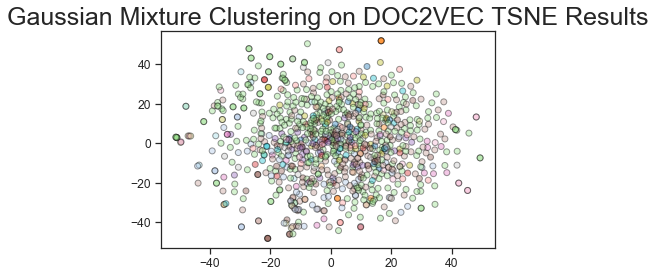

In [61]:
title = 'Gaussian Mixture Clustering on DOC2VEC TSNE Results'
plt.scatter(X_train['d2v_tsne_1'], 
            X_train['d2v_tsne_2'], 
             c=gm_pred,
             cmap='tab20',
             edgecolors='k',
           alpha=0.4)
plt.title(title, size=25)

In [63]:
from itertools import cycle
cycol = cycle('bgrcmk')

print(next(cycol))

b


In [64]:
artist_int=[]
#need to change these values below to random colors
for row in X_train['artistname']:
    # if more than a value,
    if row in ['Big Daddy Kane']:

        artist_int.append(next(cycol))

    elif row in ['Busta Rhymes']:

        artist_int.append(next(cycol))
    elif row in ['E40']:
        
        artist_int.append(next(cycol))
    elif row in ['Eminem']:

        artist_int.append(next(cycol))
    elif row in ['J. Cole']:
        
        artist_int.append(next(cycol))
    elif row in ['Kanye West']:

        artist_int.append(next(cycol))
    elif row in ['Kendrick Lamar']:
        
        artist_int.append(next(cycol))
    elif row in ['Mac Miller']:

        artist_int.append(next(cycol))
    elif row in ['Nas']:
        
        artist_int.append(next(cycol))
    elif row in ['The Notorious B.I.G.']:

        artist_int.append(next(cycol))
    elif row in ['Snoop Dogg']:
        
        artist_int.append(next(cycol))
    elif row in ['T.I.']:

        artist_int.append(next(cycol))
    elif row in ['2Pac']:
        
        artist_int.append(next(cycol))
    elif row in ['OutKast']:

        artist_int.append(next(cycol))
    elif row in ['Jeezy']:
        
        artist_int.append(next(cycol))
    elif row in ['Common']:

        artist_int.append(next(cycol))
    else:
        
        artist_int.append(next(cycol))
        
    #create a column based on this output
X_train['artist_int'] = artist_int

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5, 1.0, 'Artists on DOC2VEC TSNE Results')

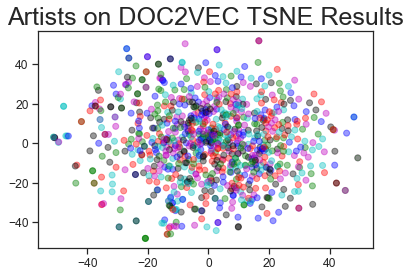

In [65]:
title = 'Artists on DOC2VEC TSNE Results'
plt.scatter(X_train['d2v_tsne_1'], 
            X_train['d2v_tsne_2'], 
            c=X_train['artist_int'],
            cmap='tab20',
            alpha=0.4)
plt.title(title, size=25)

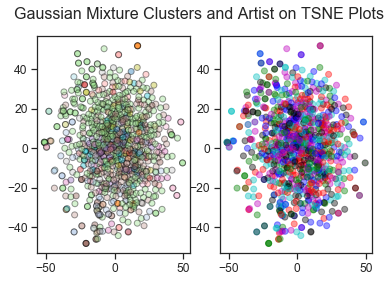

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Gaussian Mixture Clusters and Artist on TSNE Plots', fontsize=16)

ax1.scatter(X_train['d2v_tsne_1'], 
            X_train['d2v_tsne_2'], 
             c=gm_pred,
             cmap='tab20',
             edgecolors='k',
           alpha=0.4)


ax2.scatter(X_train['d2v_tsne_1'], 
            X_train['d2v_tsne_2'], 
            c=X_train['artist_int'],
            cmap='tab20',
            alpha=0.4)
plt.show()

It's difficult to discern anything from these plots. Let's cross reference the cluster results with the artists directly.

In [72]:
clusteringtable = pd.crosstab(X_train['artistname'], gm_pred, margins=True)
print(clusteringtable)

col_0                  0   1  2  3    4   5   6   7   8    9  10  11  12  13  \
artistname                                                                     
2Pac                   0   0  2  0   46   3   1   1   1    4   1   0   0   1   
Big Daddy Kane         0  10  0  1    7   0   0   0   2   20   2   0   0   0   
Busta Rhymes           1   0  0  0   41   0   1   2   5    7   1   0   7   1   
Common                 0   7  0  0    5   1   3   1   5   14   2   4   1   0   
Dilated Peoples        1  10  0  0    4   0   0   7   4    6   1   0   1   1   
E-40                   0   0  0  0   14   0   3   1   5    9   0   1   0   2   
Eminem                 2   7  2  2   39   2   1   0   0    2   3   1   2   1   
J. Cole                3   1  1  0   17   0   1   2   1   12   0   0   0   1   
Jeezy                  1   1  0  0   22   1   3   6   3   10   0   0   0   2   
Kanye West             0   7  0  1   19   1   1   3   6   18   3   3   0   3   
Kendrick Lamar         1   3  0  2   16 

This clustering alogirithm isn't picking up on artist level differences, but perhaps is picking up on something else.

Text(0.5, 1.0, 'Predicted Test Results by Gaussian Mixture Clustering on DOC2VEC TSNE Results')

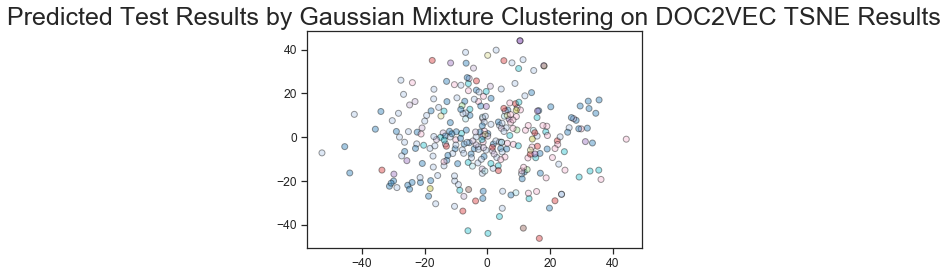

In [934]:
title = 'Predicted Test Results by Gaussian Mixture Clustering on DOC2VEC TSNE Results'
plt.scatter(X_test['d2v_tsne_1'], 
            X_test['d2v_tsne_2'], 
             c=gm.predict(X_test),
             cmap='tab20',
             edgecolors='k',
           alpha=0.4)
plt.title(title, size=25)

Once again, it's hard to discern anything visually here.

# Supervised Model

In [89]:
#drop artistname and int from train and test dataframes
#X_train=X_train.drop('artistname',1)
#X_train=X_train.drop('artist_int',1)

#X_test=X_test.drop('artistname',1)
#X_test=X_test.drop('artist_int',1)


In [79]:
params = {'n_estimators': 200,
          'max_depth': 10,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [90]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [91]:
table_test = pd.crosstab(Y_test, predict_test, margins=True)

print(table_test)

col_0                 2Pac  Big Daddy Kane  Busta Rhymes  Common  \
row_0                                                              
2Pac                     8               1             0       0   
Big Daddy Kane           0               5             0       2   
Busta Rhymes             1               2            15       0   
Common                   0               0             0       5   
Dilated Peoples          1               0             0       0   
E-40                     0               0             0       1   
Eminem                   1               1             0       1   
J. Cole                  0               0             2       0   
Jeezy                    0               0             0       0   
Kanye West               0               1             0       2   
Kendrick Lamar           1               0             1       0   
Mac Miller               0               1             0       1   
Nas                      0               1      

In [92]:
clf.score(X_test, Y_test)

0.3288590604026846

In [774]:
table_train = pd.crosstab(Y_train, predict_train, margins=True)
print(table_train)

col_0                 2Pac  Big Daddy Kane  Busta Rhymes  Common  \
row_0                                                              
2Pac                    64               0             0       0   
Big Daddy Kane           0              42             0       0   
Busta Rhymes             0               0            68       0   
Common                   0               0             0      44   
Dilated Peoples          0               0             0       0   
E-40                     0               0             0       0   
Eminem                   0               0             0       0   
J. Cole                  0               0             0       0   
Jeezy                    0               0             0       0   
Kanye West               0               0             0       0   
Kendrick Lamar           0               0             0       0   
Mac Miller               0               0             0       0   
Nas                      0               0      

Model is completely overfit to the training data. Let's try grid search cv and use random forest instead of gradient boosting on this:

In [93]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

random_classifier = RandomForestClassifier()

parameters = { 'max_features':np.arange(1,7),'n_estimators':[500],'min_samples_leaf': [10,50,100,200,500]}

random_grid = GridSearchCV(random_classifier, parameters, cv = 5)

random_grid.fit(X_train, Y_train)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': array([1, 2, 3, 4, 5, 6]), 'n_estimators': [500], 'min_samples_leaf': [10, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [94]:
best_parameters=random_grid.best_estimator_.get_params()
print(best_parameters)
print(random_grid.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.406494960806271


In [95]:
bestrandomclassifer = RandomForestClassifier(n_estimators=500, max_features=2, min_samples_leaf=1)

bestrandomclassifer.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [96]:
predict_train = bestrandomclassifer.predict(X_train)
predict_test = bestrandomclassifer.predict(X_test)

In [97]:
table_train = pd.crosstab(Y_train, predict_train, margins=True)
print(table_train)

col_0                 2Pac  Big Daddy Kane  Busta Rhymes  Common  \
row_0                                                              
2Pac                    64               0             0       0   
Big Daddy Kane           0              42             0       0   
Busta Rhymes             0               0            68       0   
Common                   0               0             0      44   
Dilated Peoples          0               0             0       0   
E-40                     0               0             0       0   
Eminem                   0               0             0       0   
J. Cole                  0               0             0       0   
Jeezy                    0               0             0       0   
Kanye West               0               0             0       0   
Kendrick Lamar           0               0             0       0   
Mac Miller               0               0             0       0   
Nas                      0               0      

In [787]:
table_test = pd.crosstab(Y_test, predict_test, margins=True)

print(table_test)

col_0                 2Pac  Big Daddy Kane  Busta Rhymes  Common  \
row_0                                                              
2Pac                     8               0             0       0   
Big Daddy Kane           0               7             1       0   
Busta Rhymes             1               0            21       1   
Common                   0               1             0       5   
Dilated Peoples          1               0             0       0   
E-40                     0               0             0       0   
Eminem                   0               1             0       0   
J. Cole                  0               1             1       1   
Jeezy                    0               0             0       0   
Kanye West               0               1             0       0   
Kendrick Lamar           1               0             0       0   
Mac Miller               0               0             0       0   
Nas                      2               0      

In [98]:
bestrandomclassifer.score(X_test, Y_test)

0.40604026845637586

The random forest model is still overfit but it performs better than the Gradient Boosted Model. Given that we are working on the song level with a relatively low number of samples and that this score of 0.40 is 7 times better than a random guess - this model is doing acceptably well given then complexity of the data.

# Unsupervised model - Neural Network

In [104]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(24,24))

mlp.fit(X_train,Y_train)

D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(24, 24), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [105]:
mlp.score(X_train,Y_train)

0.47816349384098544

In [106]:
mlp.score(X_test,Y_test)

0.412751677852349

This model is not underfit or overfit. It's just not that accurate and changing the number of hidden layers and/or sizes makes no difference to the result. Again, for context this model is 7X times better than a guess so there's something working here. Perhaps our considerations are as much a product of sample size as anything else. Let's a clustering approach instead.

# Means Shift Clustering:

In [108]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


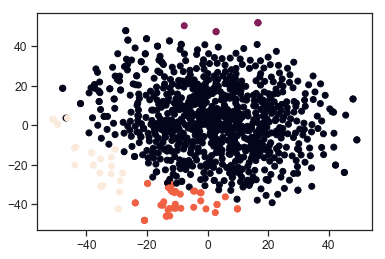

Comparing the assigned categories to the ones in the data:
col_0                  0  1   2  3
row_0                             
2Pac                  52  0   5  7
Big Daddy Kane        27  0  15  0
Busta Rhymes          63  0   5  0
Common                31  0   5  8
Dilated Peoples       37  0   0  3
E-40                  39  0   0  0
Eminem                62  0   2  1
J. Cole               39  0   0  0
Jeezy                 52  0   0  0
Kanye West            65  0   3  2
Kendrick Lamar        37  0   1  1
Mac Miller            55  0   0  2
Nas                   78  0   2  5
OutKast               40  2   3  1
Snoop Dogg            67  0   0  0
T.I.                  49  0   1  0
The Notorious B.I.G.  20  4   2  0


In [109]:
plt.scatter(X_train['d2v_tsne_1'], X_train['d2v_tsne_2'], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_train,labels))

The only thing that can discerned from this is that Big Daddy Kane, Common and 2Pac are outliers of some sort. They have a much higher propensity to be fit into clusters 2 and 3.

In [110]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_test, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_test)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 2


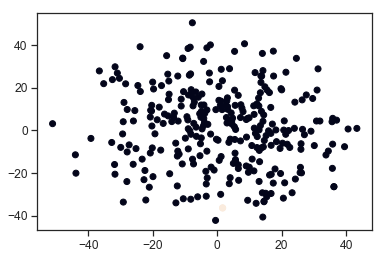

Comparing the assigned categories to the ones in the data:
col_0                  0  1
row_0                      
2Pac                  13  0
Big Daddy Kane        11  0
Busta Rhymes          24  2
Common                 7  0
Dilated Peoples       13  0
E-40                  14  0
Eminem                25  0
J. Cole               18  0
Jeezy                 13  0
Kanye West            18  0
Kendrick Lamar        16  0
Mac Miller            11  0
Nas                   33  0
OutKast               18  0
Snoop Dogg            25  0
T.I.                  28  0
The Notorious B.I.G.   9  0


In [111]:
plt.scatter(X_test['d2v_tsne_1'], X_test['d2v_tsne_2'], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y_test,labels))

Only two clusters derived here. Results are reasonably consistent with training data. Other groups do not become resolved, perhaps due to size of test data compared to training data.